In [1]:
import sklearn
print(sklearn.__version__)

0.24.0


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rc
%matplotlib inline
from matplotlib import font_manager
plt.style.use('default')
f_path = "C:/windows/Fonts/malgun.ttf"
ko_font = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family='Malgun Gothic')
#plt.title('테스트')

In [12]:
from model.ctabgan import CTABGAN
from table_evaluator import load_data, TableEvaluator
import numpy as np
import pandas as pd
import glob
#from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics
import sdmetrics

In [4]:
#Data Load

raw = pd.read_csv('C:/Users/82102/OneDrive - dongguk.edu/바탕 화면/캡스톤/data/rawdata.csv')

In [7]:
real_path = 'C:/Users/82102/OneDrive - dongguk.edu/바탕 화면/캡스톤/data/rawdata.csv'

# 범주형 변수 지정
categorical_features = [
    '저소득층여부',
    '교육수준',
    '혼인상태',
    '가구형태',
    '주택유형',
    '주택점유형태'
]

ctabgan = CTABGAN(raw_csv_path = real_path,
                  test_ratio = .2,
                  categorical_columns = categorical_features,
                  log_columns = [],
                  mixed_columns= {},
                  integer_columns = ['나이', '총소득','총생활비'],
                  problem_type= {"Classification": '저소득층여부'},
                  epochs = 150
                 ) 
ctabgan.fit()

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [30:05<00:00, 12.04s/it]

Finished training in 1807.4406368732452  seconds.


In [8]:
# Create synthetic data
nrow = len(raw)
synthetic_data = ctabgan.generate_samples()

In [9]:
raw

,저소득층여부,나이,교육수준,혼인상태,가구형태,주택유형,주택점유형태,총생활비,총소득
0,저소득층가구,78,중등,사별,단독,다가구용단독주택,자가,3300,0
1,일반가구,75,초등,사별,단독,다가구용단독주택,보증부월세,2868,2064
2,일반가구,81,대학,이혼,단독,일반단독주택,자가,1872,1200
3,일반가구,61,전문대,유배우,기타,다가구용단독주택,자가,6492,3216
4,저소득층가구,83,초등,사별,단독,일반아파트,비가구원명의주택,1020,324
...,...,...,...,...,...,...,...,...,...
7860,일반가구,42,전문대,유배우,기타,일반아파트,전세,4608,3630
7861,일반가구,46,대학,유배우,기타,일반아파트,자가,8580,5100
7862,일반가구,47,대학,유배우,기타,일반아파트,자가,7140,5500
7863,일반가구,48,대학,유배우,기타,일반아파트,전세,6744,10350


In [10]:
synthetic_data = synthetic_data[['저소득층여부', '나이', '교육수준', '혼인상태', '가구형태', '주택유형', '주택점유형태', '총생활비',
       '총소득']]

# Visualize

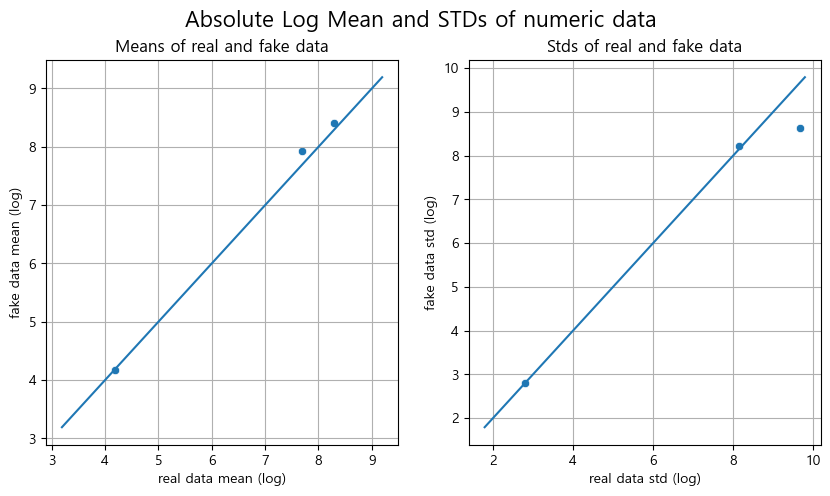

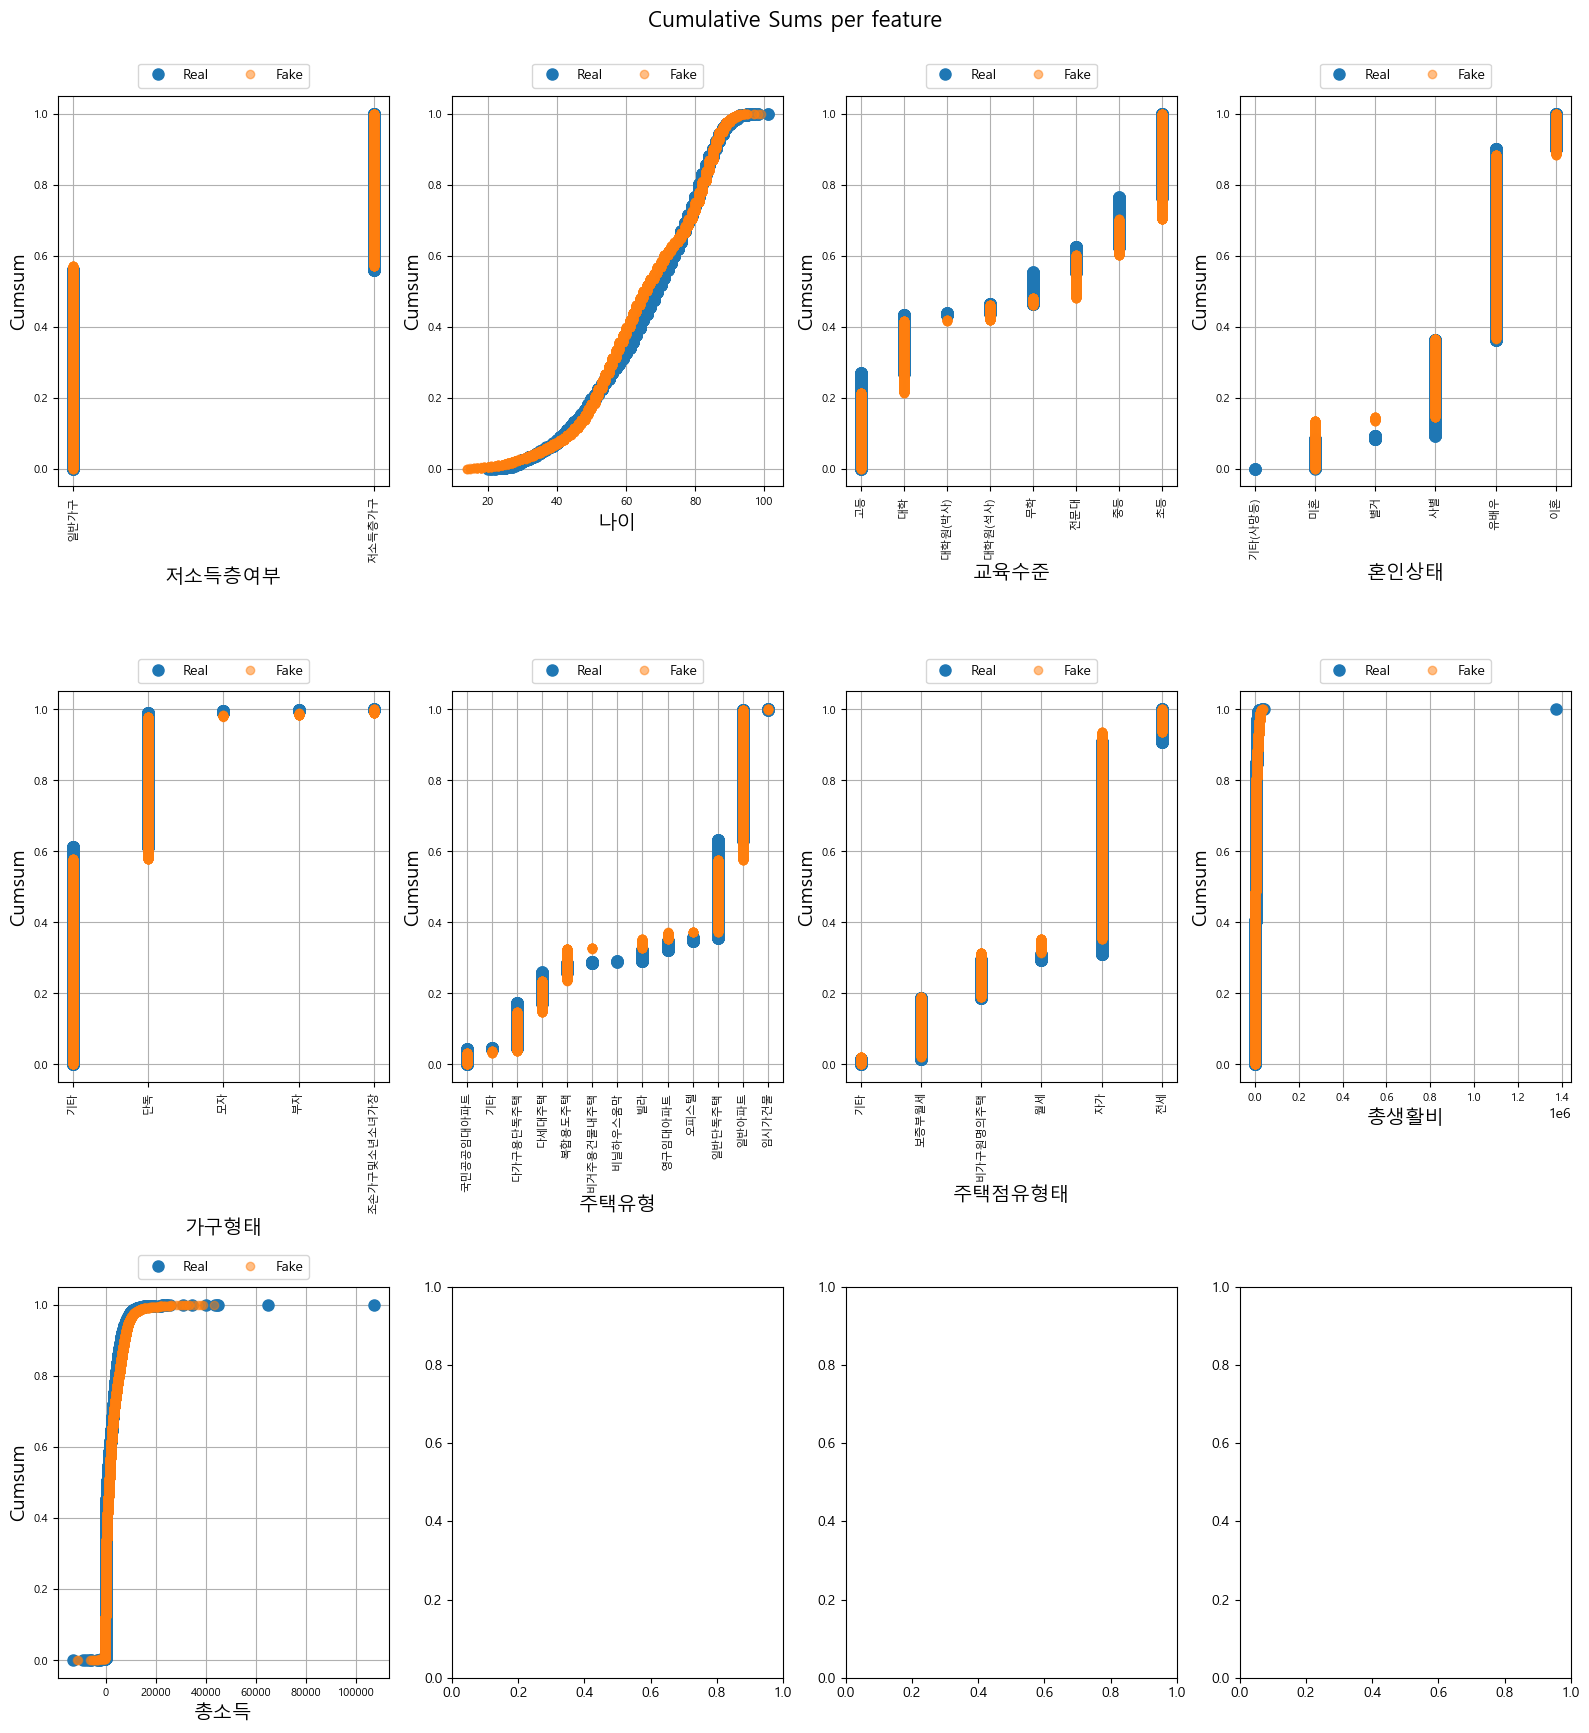

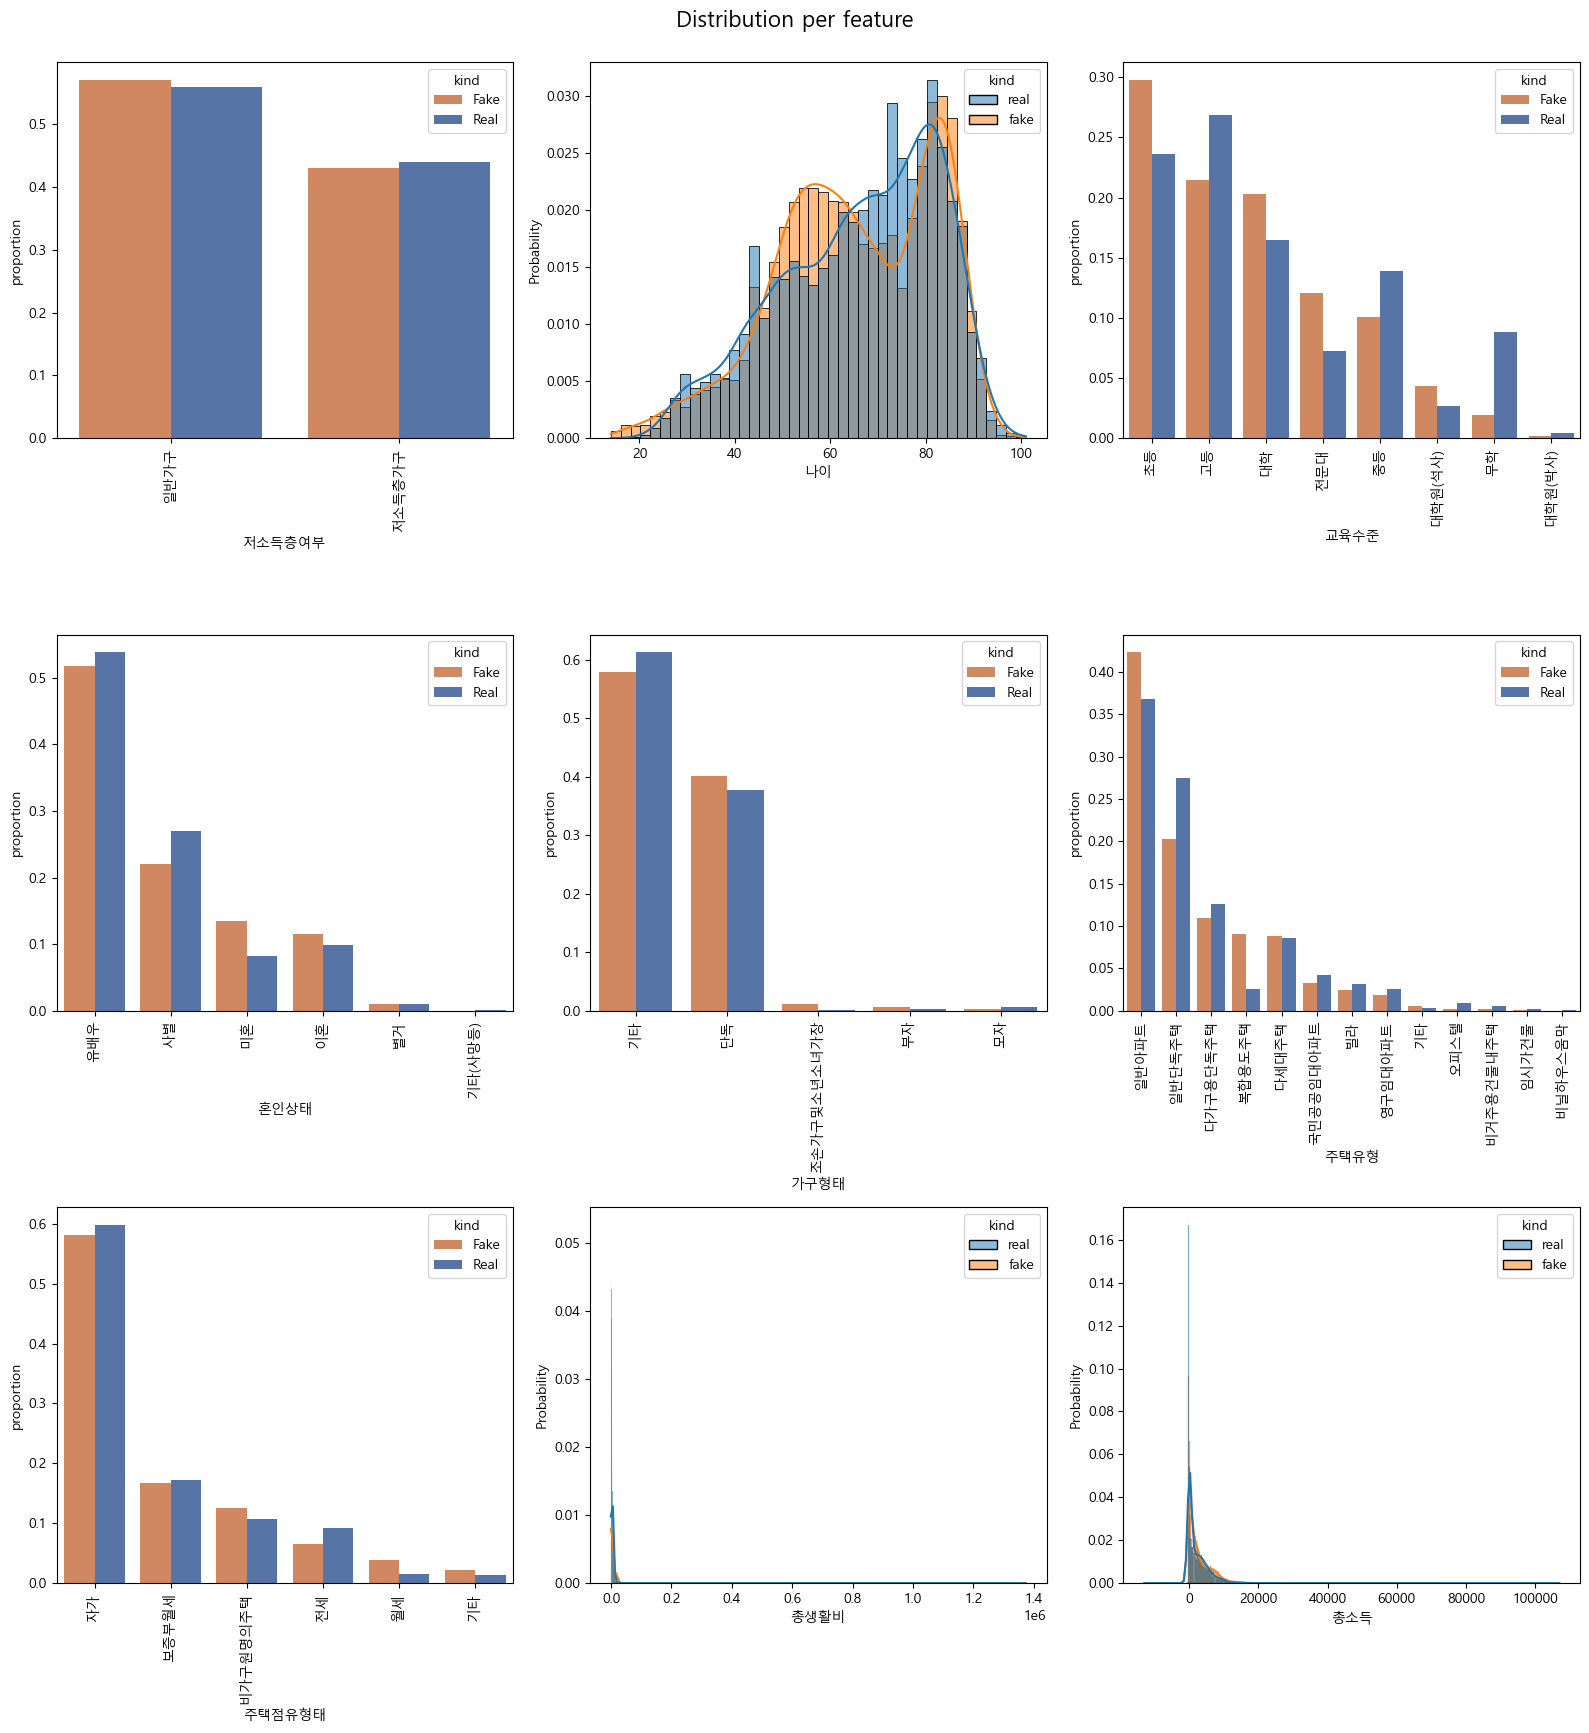

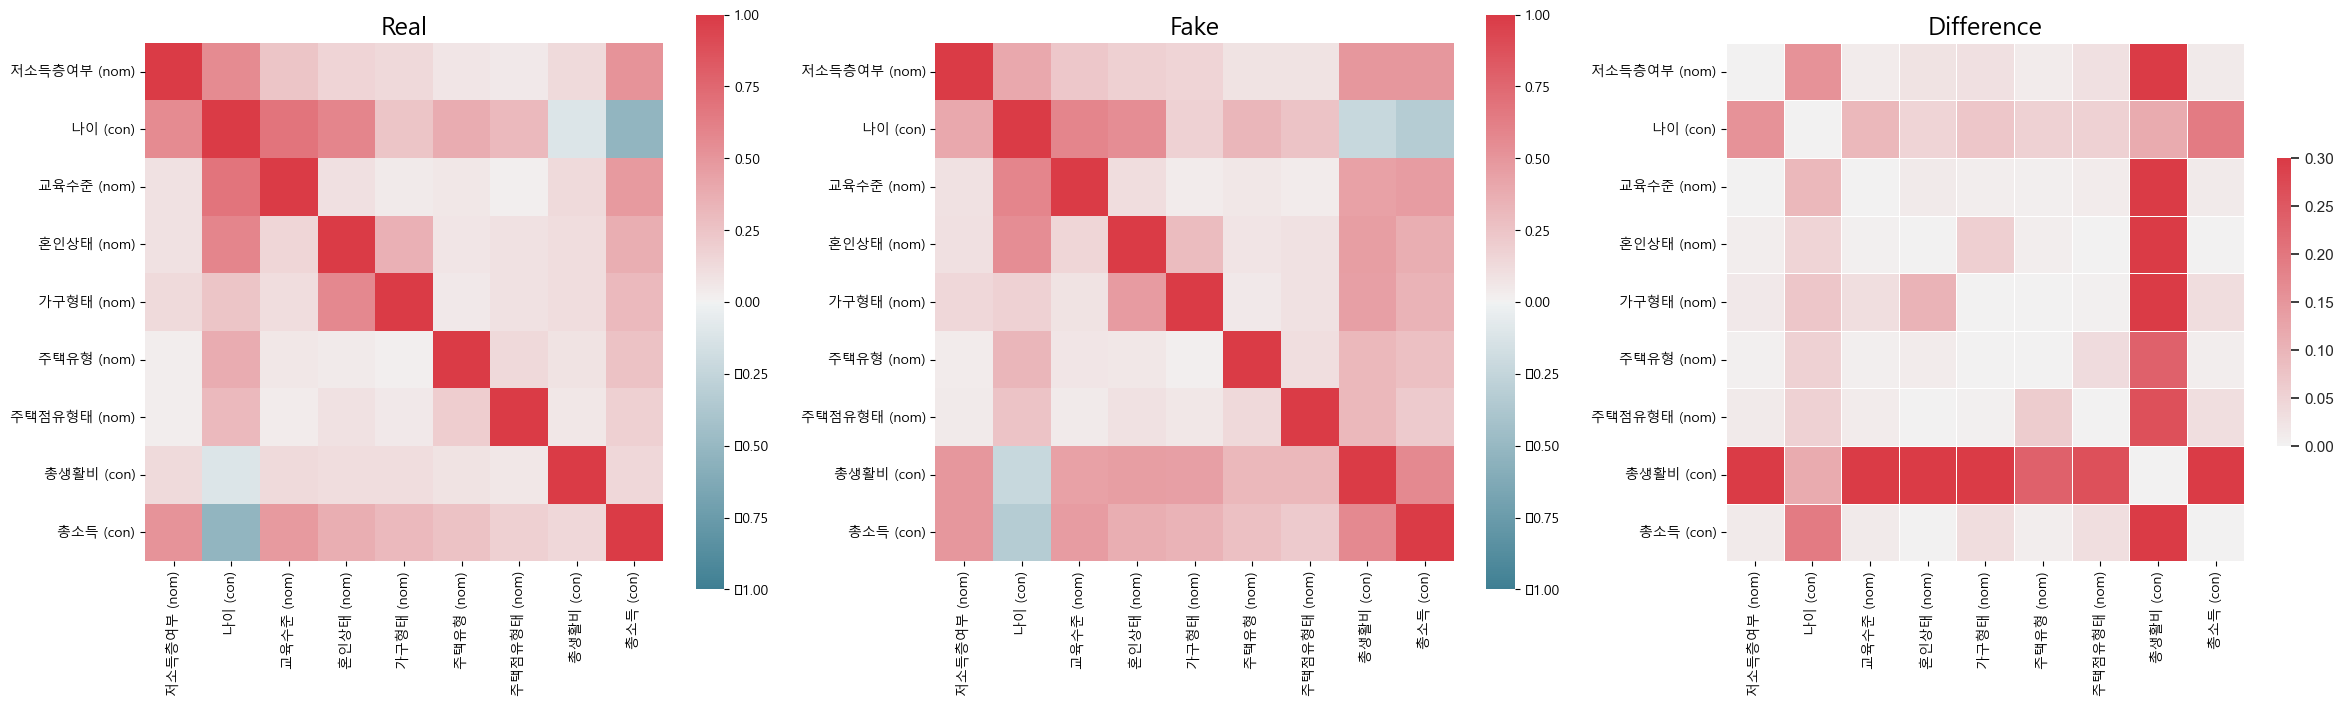

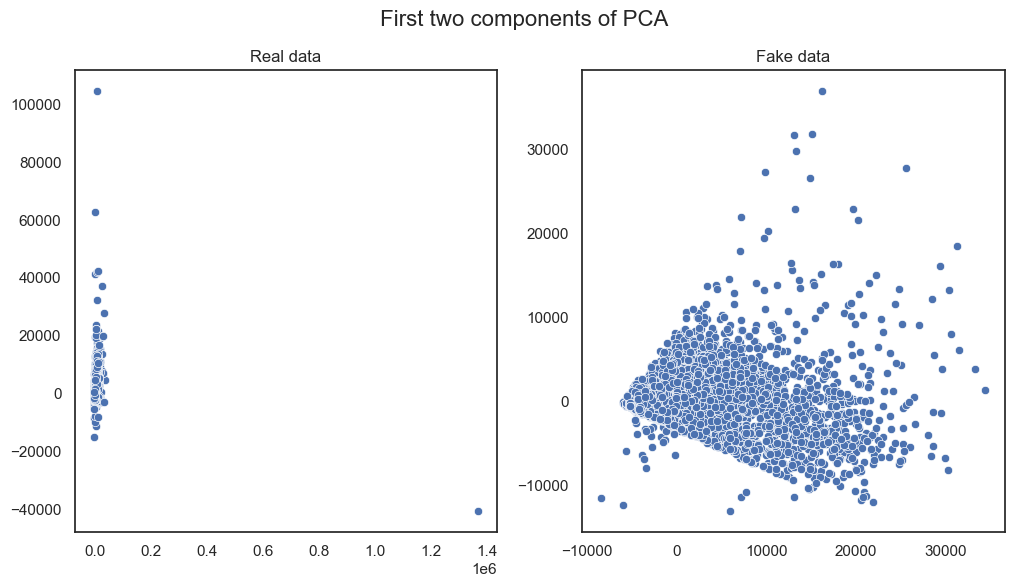

In [13]:
table_evaluator =  TableEvaluator(raw, synthetic_data, cat_cols= categorical_features)
table_evaluator.visual_evaluation()

In [14]:
from sdmetrics.reports.single_table import QualityReport

In [15]:
report = QualityReport()

In [16]:
metadata = {
    #"primary_key": "user_id",
    "columns": {
        "저소득층여부": {
            "sdtype": "object",
        },
        "나이": {
            "sdtype": "numerical"
        },
        "교육수준": {
            "sdtype": "categorical",
        }, 
        "혼인상태": {
            "sdtype": "categorical"
        },
        "가구형태": {
            "sdtype": "categorical"
        },
        "주택유형": {
            "sdtype": "categorical"
        },
        "주택점유형태": {
            "sdtype": "categorical"
        },
        "총생활비": {
            "sdtype": "numerical"
        },
        "총소득": {
            "sdtype": "numerical"
        }
    }
}

# 통계적 유사성

In [17]:
report.generate(raw, synthetic_data, metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|███████████████████████████████████████████| 36/36 [00:00<00:00, 68.11it/s]

Overall Quality Score: 76.49%

Properties:
- Column Shapes: 89.59%
- Column Pair Trends: 63.39%


# KStest and TVtest

In [18]:
report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,나이,KSComplement,0.934393
1,교육수준,TVComplement,0.834965
2,혼인상태,TVComplement,0.930579
3,가구형태,TVComplement,0.963255
4,주택유형,TVComplement,0.876414
5,주택점유형태,TVComplement,0.951685
6,총생활비,KSComplement,0.855817
7,총소득,KSComplement,0.819708


In [19]:
report.get_properties()

,Property,Score
0,Column Shapes,0.895852
1,Column Pair Trends,0.633907


# TCAP

In [20]:
from sdmetrics.single_table import CategoricalCAP

TCAP_score = CategoricalCAP.compute(
    real_data=raw,
    synthetic_data=synthetic_data,
    key_fields=['나이'],
    sensitive_fields=['저소득층여부', '총소득']
)

In [21]:
TCAP_score

0.9992083879356507

# pMSE

In [22]:
def pMSE(real, fake):
    
    real['target'] = 0
    fake['target'] = 1

    merge = pd.concat([real, fake])
    # 학습데이터, taget 분리
    X = merge.drop(['target'], axis = 1)
    Y = merge['target']

    # 범주형 변수 One-hot Encoding, 수치형 변수는 Scaling
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import OneHotEncoder

    cate_X = merge[['저소득층여부','교육수준','혼인상태','가구형태','주택유형','주택점유형태','가구서비스','노인서비스','아동서비스']]
    conti_X = merge[['나이','총생활비','총소득']]

    cate_X_dummy=pd.get_dummies(cate_X)

    scaler_X=StandardScaler()
    conti_X_st=scaler_X.fit_transform(conti_X)

    conti_X_st=pd.DataFrame(conti_X_st, columns=conti_X.columns)

    cate_X_dummy.reset_index(inplace=True, drop=True)
    conti_X_st.reset_index(inplace=True, drop=True)
    Y.reset_index(inplace=True, drop=True)

    # train set
    train_set=pd.concat([conti_X_st,cate_X_dummy, Y], axis=1)
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    
    #Logistic Reggression
    model_log = LogisticRegression(penalty = 'l2', solver='saga', random_state=0) 
    model_log.fit(train_set, Y) # 모델 학습

    y_pred= model_log.predict_proba(train_set) # 예측 라벨

    s = 0
    n0 = len(real)
    n1 = len(fake)
    for score in y_pred:
        s+= (score[0] - (n1/(n0+n1)))**2

    pMSE_logistic = s*(1/(n0+n1))

    #RandomForest
    model_rf = RandomForestClassifier(random_state=0) 
    model_rf.fit(train_set, Y) # 모델 학습

    y_pred= model_rf.predict_proba(train_set) # 예측 라벨

    s = 0
    n0 = len(real)
    n1 = len(fake)
    for score in y_pred:
        s+= (score[0] - (n1/(n0+n1)))**2

    pMSE_rf = s*(1/(n0+n1))

    #SVM
    model_svc = SVC(kernel = 'rbf', probability=True)
    model_svc.fit(train_set, Y) # 모델 학습

    y_pred= model_svc.predict_proba(train_set) # 예측 라벨

    s = 0
    n0 = len(real)
    n1 = len(fake)
    for score in y_pred:
        s+= (score[0] - (n1/(n0+n1)))**2

    pMSE_svm = s*(1/(n0+n1))

    #3가지 분류기 평균값 도출
    pMSE = (pMSE_logistic + pMSE_rf + pMSE_svm)/3
    
    return pMSE

In [23]:
ctabgan_pMSE = pMSE(raw, synthetic_data)

ctabgan_pMSE

0.24200585695477236